In [1]:
import numpy as np
from numpy import pi
import pandas as pd
import scipy.optimize as optimize
from scipy import interpolate
from scipy.optimize import fsolve

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, FixedFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from IPython.display import display, HTML, Video
import IPython

from numpy.polynomial.hermite import hermval
from math import factorial
from skimage import measure
import cv2
import finesse
from finesse.gaussian import HGMode

finesse.configure(plotting=True)

(0.17249076834494562+0j)
49765545.873874106
(3.0413216129604293e-21+0j)
(0.17249076834494562+0j)
49765545.873874106
(3.0413216129604293e-21+0j)


(-0.5, 399.5, -0.5, 399.5)

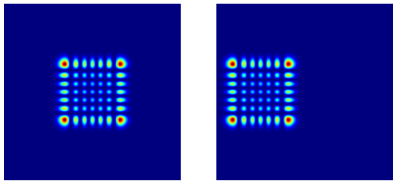

In [2]:
q_0 = 1j 
x = y = np.linspace(-0.004, 0.004, 400)

HG00 = HGMode(q_0, n=6, m=6)
HG00_data = HG00.unm(x, y);
HG00_data_offset = HG00.unm(x, y-y[0]/2);

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(7, 5))
ax1.imshow(np.abs(HG00_data)**2, cmap="jet")
ax2.imshow(np.abs(HG00_data_offset)**2, cmap="jet")
ax1.axis("off")
ax2.axis("off")
# fig.savefig('HG00.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

(5.3444309853959675+0j)
-860.0898201517888
(7.426181972671784e-06+0j)


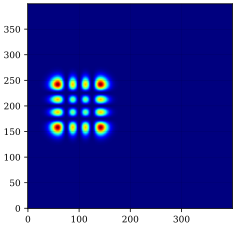

In [3]:
def UnmLateralOffset(q, n, m, x0):
    HGmn = HGMode(q, m=m, n=n)

    U_n = HGmn.un(x+x0)
    U_m = HGmn.um(y)
    U_mn = np.outer(U_m, U_n)

    return U_mn

HG33 = UnmLateralOffset(1j, 3, 3, -x[0]/2)
plt.imshow(np.abs(HG33)**2, cmap="jet");

$$q_0 = z_{0} + 1j \cdot z_{R0} $$
$$\delta z = - \gamma \cdot z_{R0}/2 $$
$$w = (\epsilon + 1) \cdot w_{0} $$
$$z_R = \pi w^2/\lambda = z_{R0} \cdot (\epsilon + 1)^2 $$
$$q^{\prime} = z_{0} - \gamma \cdot z_{R0}/2 + 1j \cdot z_{R0} \cdot (\epsilon + 1)^2 $$

In [54]:
x = y = np.linspace(-0.004, 0.004, 400)
step = x[1] - x[0]
def eta_nn(n, q_0, q_prime):
    HGnn_0 = HGMode(q_0, n=n, m=n)
    HGnn_prime = HGMode(q_prime, n=n, m=n)
    
    HGnn_0_data = HGnn_0.unm(x, y)
    HGnn_prime_data = HGnn_prime.unm(x, y)
    
    rho_nn = np.sum(np.conj(HGnn_0_data)*HGnn_prime_data * step * step)
    eta = np.abs(rho_nn*np.conj(rho_nn))

    if n == 0:
        HG20 = HGMode(q_0, n=2, m=0)
        HG02 = HGMode(q_0, n=0, m=2)
        HG20_data = HG20.unm(x, y)
        HG02_data = HG02.unm(x, y)
                
        rho_20 = np.sum(np.conj(HG20_data)*HGnn_prime_data * step * step)
        rho_02 = np.sum(np.conj(HG02_data)*HGnn_prime_data * step * step)
        eta_2nd = np.abs(rho_20*np.conj(rho_20)) + np.abs(rho_02*np.conj(rho_02))

        return eta, eta_2nd
    
    return eta

In [1]:
q_0 = 1j 
zR = np.imag(q_0)
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
zs = np.linspace(0.0001, 1, 400)*5*zR
HOMFactorss = []
powerMM = []
powerMM_2nd = []
for idx, z in enumerate(zs):
    q_prime = q_0 + z

    eta, eta_2nd = eta_nn(0, q_0, q_prime)

    powerMM.append(1-eta)
    powerMM_2nd.append(eta_2nd)

powerMM_ana = 1/16*((2*1064e-9/np.pi/w0**2)*zs)**2

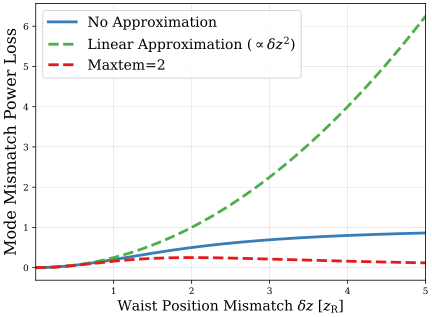

In [60]:
lw = 2.8
fig, ax = plt.subplots(figsize=(7, 5))

ax.set_ylabel("Mode Mismatch Power Loss", fontsize=16)
ax.set_xlabel(r"Waist Position Mismatch $\delta z$ [$z_{\mathrm{R}}$]", fontsize=14)

ax.plot(zs/zR, powerMM, label="No Approximation", lw=lw, color=CB_color_cycle[0])
ax.plot(zs/zR, powerMM_ana, ls='--', label=r"Linear Approximation ($\propto \delta z^2$)", lw=lw, color=CB_color_cycle[2])
ax.plot(zs/zR, powerMM_2nd, ls="--", label="Maxtem=2", lw=lw, color=CB_color_cycle[1])

legends = plt.legend(fontsize=14, ncols=1, loc="upper left");
# ax.add_artist(legends);

In [5]:
# q_0 = 1j 
# HOMFactorss = []

# # MMs = np.linspace(0.0001, 0.105, 500)
# MMs = np.linspace(0.0001, 0.2, 500)
# powerMM = []
# ratio = 0
# smallnum = 0.1
# temp = 1
# index_12 = 0
# for idx, MM in enumerate(MMs):
#     epsilon = np.sqrt(ratio*MM)
#     gamma = np.sqrt((1-ratio)*MM*16)
#     q_prime = q_0.real - q_0.imag*gamma/2 + 1j*q_0.imag*(1+epsilon)**2

#     etas = []
#     for n in range(7):
#         etas.append(eta_nn(n, q_0, q_prime))

#     powerMM.append(1-etas[0])
#     # if abs(1-etas[0]-MM_measured) < temp:
#     #     index_12 = idx
#     #     temp = abs(1-etas[0]-MM_measured)
    
#     HOMFactors = []
#     for n in range(1, 7):
#         HOMFactors.append((1 - etas[n])/(1-etas[0]))

#     HOMFactorss.append(HOMFactors)
# HOMFactorss_wp = np.array(HOMFactorss)
# powerMM_wp = np.array(powerMM)


# ratio = 1
# HOMFactorss = []
# powerMM = []
# MMs = np.linspace(0.0001, 0.2, int(500/1.3))
# for idx, MM in enumerate(MMs):
#     epsilon = np.sqrt(ratio*MM)
#     gamma = np.sqrt((1-ratio)*MM*16)
#     q_prime = q_0.real - q_0.imag*gamma/2 + 1j*q_0.imag*(1+epsilon)**2

#     # epsilon = np.sqrt(ratio*MM)
#     # gamma = np.sqrt((1-ratio)*MM)
#     # q_prime = q_0.real + gamma + 1j*(q_0.imag + epsilon)
    
#     etas = []
#     for n in range(7):
#         etas.append(eta_nn(n, q_0, q_prime))

#     powerMM.append(1-etas[0])
    
#     HOMFactors = []
#     for n in range(1, 7):
#         HOMFactors.append((1 - etas[n])/(1-etas[0]))

#     HOMFactorss.append(HOMFactors)
# HOMFactorss_ws = np.array(HOMFactorss)
# powerMM_ws = np.array(powerMM)

In [2]:
q_0 = 1j 
zR = np.imag(q_0)
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
zs = np.linspace(0.0001, 1, 400)*0.55*zR
HOMFactorss = []
powerMM = []
powerMM_2nd = []
for idx, z in enumerate(zs):
    q_prime = q_0 + z

    etas = []
    for n in range(7):
        etas.append(eta_nn(n, q_0, q_prime))

    powerMM.append(1-etas[0])
    
    HOMFactors = []
    for n in range(1, 7):
        HOMFactors.append((1 - etas[n])/(1-etas[0]))

    HOMFactorss.append(HOMFactors)
HOMFactorss_wp = np.array(HOMFactorss)
powerMM_wp = np.array(powerMM)

In [7]:
MM_Measurement_11 = [2.9880572164613977,
6.449858213968795,
12.29315190261705,
18.223775446158673,
27.37886737543383,
34.48822772180121,]

MM_Measurement_21 = [3.1813953842602536,
6.633656959142354,
11.447291278218344,
16.90872269471425,
23.30957106668674,
28.83790267699762,]

MM_Measurement_32 = [2.934021871760781,
6.385424015007302,
10.578883678510078,
15.167613136756637,
19.898024058507005,
23.64987430054891,]

In [8]:
0.011947537081386283/2.998133669489736

0.003984991464179674

In [9]:
MM_Measurement_32_nominal = [3.085387190132749, 6.712822449192771, 11.297233188343425, 15.951794114623924, 
                            20.529743550101964, 24.370965793912003]
MM_Measurement_32_err = [0.07827635048290217, 0.1494565371492781, 0.272564242214205, 0.3878439777609574, 
                        0.4623969990517415, 0.5363694248759736]

MM_Measurement_32_nominal_00 = [0.03001122271886973*100]*len(MM_Measurement_32_nominal)
MM_Measurement_32_err_00 = [0.0006285935590159794*100]*len(MM_Measurement_32_nominal)


MM_Measurement_22_nominal = [3.1830008934907403, 6.636533437148509, 11.461781968885633, 16.921603340537853, 
                            23.329727501345705, 28.85752931053126]
MM_Measurement_22_err = [0.10859822706778598, 0.17690769569997442, 0.2891307494600311, 0.462065293484942, 
                        0.5957843736502016, 0.7176838886433294]

MM_Measurement_22_nominal_00 = [0.021817619118138388*100]*len(MM_Measurement_22_nominal)
MM_Measurement_22_err_00 = [0.0005227808250475741*100]*len(MM_Measurement_22_nominal)

MM_Measurement_11_nominal = [2.998133669489736, 6.464814332893549, 12.341548526341388, 18.29274840255331, 
                            27.446288432350702, 34.59334538502472]
MM_Measurement_11_err = [0.17217566717623445, 0.19995234727449346, 0.33217102847057384, 0.4584830513916551, 
                         0.769874966746894, 0.9414410403810648]

MM_Measurement_11_nominal_00 = [0.011947537081386283*100]*len(MM_Measurement_11_nominal)
MM_Measurement_11_err_00 = [0.00056066638793002144*100]*len(MM_Measurement_11_nominal)

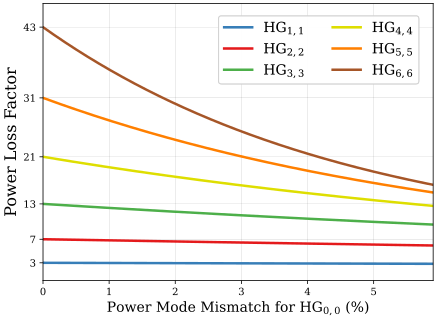

In [10]:
CB_color_cycle = ['#377eb8', '#e41a1c', '#4daf4a',
                  '#dede00', '#ff7f00', '#a65628', '#984ea3',
                  '#999999',  '#f781bf',]
colors = plt.cm.get_cmap("jet", 7)

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel("Power Mode Mismatch for $\mathrm{{HG}}_{0,0}$ (%)", fontsize=14)
ax.set_ylabel("Power Loss Factor", fontsize=16)

# measurement = powerMM[index_12]*100
measured_Factors = []
for n in range(0,6):
    ax.plot(powerMM_wp[:]*100, HOMFactorss_wp[:,n], label=f"$\mathrm{{HG}}_{{{n+1},{n+1}}}$", lw=2.5, 
            color=CB_color_cycle[n])
ax.set_ylim([0, 47])
# ax.set_ylim([2, 4])
ax.set_xlim([-0., 5.9])

ax.set_yticks([n**2+n+1 for n in range(1, 7)])
ax.set_xticks([0, 1, 2, 3, 4, 5,])
ax.set_xticklabels([0, 1, 2, 3, 4, 5,])

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='minor', color='r', linestyle='-', alpha=0.)

legends = plt.legend(fontsize=14, ncols=2, loc=(0.45, 0.71));
ax.add_artist(legends);

# fig.savefig('./Experiment Paper/ModeMismatchHOM.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/powerloss_modemismatch_big.pdf', 
#     bbox_inches='tight', dpi=300, pad_inches=0.01);


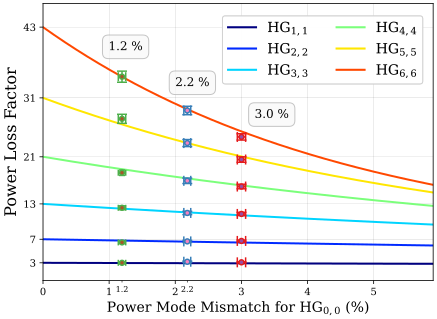

In [11]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

colors = plt.cm.get_cmap("jet", 7)

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel("Power Mode Mismatch for $\mathrm{{HG}}_{0,0}$ (%)", fontsize=14)
ax.set_ylabel("Power Loss Factor", fontsize=16)

# measurement = powerMM[index_12]*100
measured_Factors = []
for n in range(0,6):
    ax.plot(powerMM_wp[:]*100, HOMFactorss_wp[:,n], label=f"$\mathrm{{HG}}_{{{n+1},{n+1}}}$", lw=2, 
            color=colors(n))
    # ax.plot(powerMM_ws[:]*100, HOMFactorss_ws[:,n], lw=1.8, color=colors(n))
    # print(HOMFactorss_1[index_12, n])

    # ax.scatter(0.011*100, MM_Measurement_11[n], s=90, linewidths=4, marker="+", color=colors(n),)
    # ax.scatter(0.022*100, MM_Measurement_21[n], s=80, linewidths=1, marker="X", color=colors(n),)
    # ax.scatter(0.032*100, MM_Measurement_32[n], s=80, linewidths=2.5, marker="*", color=colors(n),)

ax.errorbar(MM_Measurement_32_nominal_00, MM_Measurement_32_nominal, color=CB_color_cycle[7], 
            xerr=MM_Measurement_32_err_00, yerr=MM_Measurement_32_err, ls="",
                capsize=5, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[5],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_22_nominal_00, MM_Measurement_22_nominal, color=CB_color_cycle[0], 
            xerr=MM_Measurement_22_err_00, yerr=MM_Measurement_22_err, ls="",
                capsize=5, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[3],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_11_nominal_00[4:], MM_Measurement_11_nominal[4:], color=CB_color_cycle[2], 
            xerr=MM_Measurement_11_err_00[4:], ls="",
                capsize=4.5, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[4],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_11_nominal_00[4:], MM_Measurement_11_nominal[4:], color=CB_color_cycle[2], 
            yerr=MM_Measurement_11_err[4:], ls="",
                capsize=5, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[4],
                markersize=0, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_11_nominal_00[:4], MM_Measurement_11_nominal[:4], color=CB_color_cycle[2], 
            xerr=MM_Measurement_11_err_00[:4], yerr=MM_Measurement_11_err[:4], ls="",
                capsize=3, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[4],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

# ax.vlines(x=measurement, ymin=0, ymax=46, color="g", alpha=1, lw=2., ls="--")
ax.set_ylim([0, 47])
# ax.set_ylim([2, 4])
ax.set_xlim([-0., 5.9])

ax.set_yticks([n**2+n+1 for n in range(1, 7)])
ax.set_xticks([0, 1, 2, 3, 4, 5,])
ax.set_xticklabels([0, 1, 2, 3, 4, 5,])
# ax.xaxis.get_majorticklabels()[1].set_y(0.08)

ax.xaxis.set_minor_locator(plt.FixedLocator([1.1947537081386283, 2.1817619118138388,]))
minor_tick_formatter = FixedFormatter([1.2, 2.2, ])

ax.xaxis.set_minor_formatter(minor_tick_formatter)
# for tick in ax.xaxis.get_minor_ticks():
#     tick.label1.set_horizontalalignment('right')
ax.xaxis.get_minor_ticks()[0].label1.set_horizontalalignment('center')
ax.xaxis.get_minor_ticks()[1].label1.set_horizontalalignment('center')
# ax.set_xticklabels(empty_string_labels)

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='minor', color='r', linestyle='-', alpha=0.)

# handles, labels = ax.get_legend_handles_labels()
# legend = plt.legend([handles[-1]], [labels[-1]], fontsize=16, ncols=2, loc=(0.35, 0.61));
# ax.add_artist(legend);

ax.text(
    0.99, 39.1,  # Coordinates where you want to place the text (adjust as needed)
    '1.2 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
        # fontdict={'size': 12,}
    )
)

ax.text(
    2.0, 33,  # Coordinates where you want to place the text (adjust as needed)
    '2.2 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
    )
)

ax.text(
    3.2, 27.6,  # Coordinates where you want to place the text (adjust as needed)
    '3.0 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
    )
)

legends = plt.legend(fontsize=14, ncols=2, loc=(0.46, 0.71));
ax.add_artist(legends);

# fig.savefig('./Experiment Paper/ModeMismatchHOM.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Experiment/ModeMismatchHOM.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [273]:
11.2*3

33.599999999999994

In [14]:
q_0 = 1j 
zR = q_0.imag
def fsolve_func(y, alpha, x):
    point1 = [x*np.sin(alpha), x*np.cos(alpha)]
    point2 = [-zR**2/y, 0]
    distance = ((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)**0.5

    return np.where(x>0, distance - (y+zR**2/y), distance + (y+zR**2/y))
    
def phase_tilt(alpha, x):
    y = fsolve(fsolve_func, x0=x*alpha, args=(alpha, x))
    phase = np.arctan(y/zR)
    # print(y)

    return y

In [13]:
x = y = np.linspace(-0.004, 0.004, 400)
step = x[1]-x[0]
def eta_n(n, delta_x=0, alpha=0):
    HGnn_0 = HGMode(q_0, n=n, m=n)

    HGnn_0_data = HGnn_0.unm(x, y)
    
    HGnn_prime_data = HGnn_0.unm(x-delta_x, y)*np.exp(1j*2*np.pi/(1064e-9)*np.sin(alpha)*x)
    # HGnn_prime_data = UnmLateralOffset(q_0, n, n, delta_x)*np.exp(1j*2*np.pi/(1064e-9)*np.sin(alpha)*x)
        
    rho_nn = np.sum(np.conj(HGnn_0_data)*HGnn_prime_data * step * step)
    eta = np.abs(rho_nn*np.conj(rho_nn))
    
    return eta

In [14]:
# ratio = 0
# for idx, MA in enumerate(Misalignments):
#     etas = []
#     w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
#     delta_x=(ratio*MA)**0.5*w0
#     alpha=(2*(1-ratio)*MA)**0.5*((1064e-9)/np.pi/w0)
#     print(alpha)

In [3]:
q_0 = 1j 
HOMFactorss = []
Misalignments = np.linspace(0.0001, 0.2, 500)
powerMisalignment = []
ratio = 0
# measurement = 0.1
# temp = 1
for idx, MA in enumerate(Misalignments):
    etas = []
    w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
    delta_x=(ratio*MA)**0.5*w0
    alpha=((1-ratio)*MA)**0.5*((1064e-9)/np.pi/w0)
    for n in range(7):
        etas.append(eta_n(n, delta_x=delta_x, alpha=alpha))

    powerMisalignment.append(1-etas[0])
    # if abs(1-etas[0]-measurement) < temp:
    #     index_1 = idx
    #     temp = abs(1-etas[0]-measurement)
        
    HOMFactors = []
    for n in range(1, 7):
        HOMFactors.append((1 - etas[n])/(1-etas[0]))

    HOMFactorss.append(HOMFactors)

HOMFactorss_a = np.array(HOMFactorss)
powerMisalignment_a = np.array(powerMisalignment)

ratio = 1
HOMFactorss = []
powerMisalignment = []
for idx, MA in enumerate(Misalignments):
    etas = []
    w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
    delta_x=(ratio*MA)**0.5*w0
    alpha=(2*(1-ratio)*MA)**0.5*((1064e-9)/np.pi/w0)
    for n in range(7):
        etas.append(eta_n(n, delta_x=delta_x, alpha=alpha))
        
    powerMisalignment.append(1-etas[0]) 
    HOMFactors = []
    for n in range(1, 7):
        HOMFactors.append((1 - etas[n])/(1-etas[0]))

    HOMFactorss.append(HOMFactors)

HOMFactorss_x = np.array(HOMFactorss)
powerMisalignment_x = np.array(powerMisalignment)

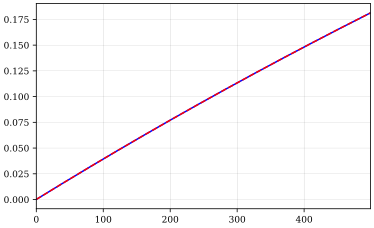

In [16]:
plt.plot(powerMisalignment_x)
plt.plot(powerMisalignment_a, "--");

In [17]:
MM_5 = [2.8988508498690706, 
4.652410852058357, 
6.26895064872315, 
7.756369483856959, 
9.12220893854303, 
10.373666234853303, ]

MM_2 = [2.9598317971416708,
4.860422097368363,
6.70309962572056,
8.489169622370568,
10.21991418429684,
11.89659260274779,]

MM_9 = [2.7963119117142483,
4.313341746996518,
5.583545692798174,
6.636399037032011,
7.4986218431457266,
8.194390109080352,]


MM_2_Measurement = [2.67534685,  4.57753003,  7.00460627,  8.42077519,
       10.17989848, 12.22829268]

MM_5_Measurement = [2.84770865,  4.48606498,  6.12194679,  7.40192371,
        9.47299611, 10.54574257]

MM_9_Measurement = [2.80842491, 4.27058824, 5.59038462, 6.65759162,
       7.37420965, 8.09134615]

# MM_Measurement_9_err = np.array(MM_9_Measurement)*0.0010359649615325622

MM_3_Measurement = [2.9779705554397187, 4.8091791816505705, 6.542639806477987, 8.17261029837126, 9.749180756672182, 
        11.209650965426475]

MM_5_Measurement = [2.854482230604491, 4.607535017858313, 6.279125899051509,
                    7.625894743455661, 8.908960325258171, 10.356996879791167, ]

MM_1d7_Measurement = [2.953187304792409, 4.91451679657022, 6.738779539215405, 8.564494660846387,
                      10.304925061790176, 11.994088199508933]

In [18]:
MM_Measurement_9_nominal = [2.786569389310873, 4.338809116910841, 5.740865557820227, 6.638606532469046, 
                           7.7127286014175676, 8.51629462881049]
MM_Measurement_9_err = [0.06472510508394526, 0.08929393867187461, 0.12587099393829865, 0.11734549566897523,
                       0.15423697709038298, 0.15053593093566256]


MM_Measurement_9_nominal_00 = [0.0959939939237781*100]*len(MM_Measurement_9_nominal)
MM_Measurement_9_err_00 = [0.0016968113327904724*100]*len(MM_Measurement_9_nominal)

MM_Measurement_5_nominal = [2.845173798345565, 4.6144715488938575, 6.32109653825017, 7.696588653654235, 
                           9.112200221689188, 10.402943587820245]
MM_Measurement_5_err = [0.06959233144184272, 0.11635197777044608, 0.12570759108520357, 0.162787130774799, 
                       0.18656567772989308, 0.20264636855080453]

MM_Measurement_5_nominal_00 = [0.050722924544637144*100]*len(MM_Measurement_5_nominal)
MM_Measurement_5_err_00 = [0.0009401757639449993*100]*len(MM_Measurement_5_nominal)

MM_Measurement_1d7_nominal = [2.94740660171021, 4.903350415581596, 6.770017452392313, 8.499538778617747, 
                             10.227899326812228, 11.931893350233922]
MM_Measurement_1d7_err = [0.025313207662795528, 0.040880721451788046, 0.05598838830518907, 0.07142172945999599, 
                         0.08637167671212416, 0.10045408944118094]

MM_Measurement_1d7_nominal_00 = [0.017690610505596584*100]*len(MM_Measurement_1d7_nominal)
MM_Measurement_1d7_err_00 = [0.00014450455170627086*100]*len(MM_Measurement_1d7_nominal)

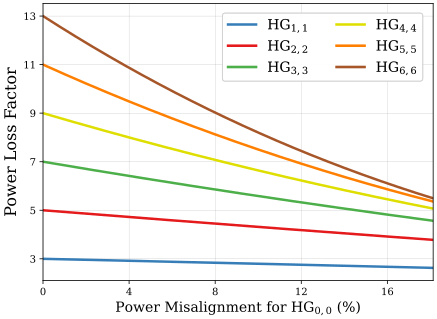

In [19]:
colors = plt.cm.get_cmap("jet", 7)
CB_color_cycle = ['#377eb8', '#e41a1c', '#4daf4a',
                  '#dede00', '#ff7f00', '#a65628', '#984ea3',
                  '#999999',  '#f781bf',]

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel(r"Power Misalignment for $\mathrm{HG}_{0,0}$ (%)", fontsize=14)
ax.set_ylabel("Power Loss Factor", fontsize=16)

measured_Factors = []
for n in range(6):
    ax.plot(powerMisalignment_a*100, HOMFactorss_a[:,n], label=f"$\mathrm{{HG}}_{{{n+1},{n+1}}}$", 
            lw=2.5, color=CB_color_cycle[n], alpha=1) 

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.set_yticks([2*n+1 for n in range(1, 7)])
ax.set_xticks(np.linspace(0, 16, 5))

legends = plt.legend(fontsize=14, ncols=2, loc=(0.46, 0.72));
ax.add_artist(legends);

# legend = plt.legend(handles, labels, fontsize=14, ncols=2, loc=(0.45, 0.71));
# # ax.add_artist(legend);

# ax.grid(True, which='minor', color='r', linestyle='-', alpha=0.)

# ax.plot([0.0285*100], [6.536434108527154], ".", markersize=20)
# plt.gcf().savefig('./Experiment Paper/MisalignmentHOM.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/powerloss_misalignment_big.pdf', 
#     bbox_inches='tight', dpi=300, pad_inches=0.01);

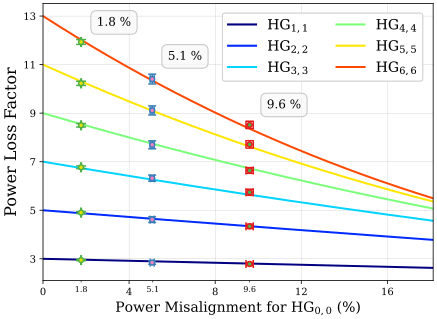

In [23]:
colors = plt.cm.get_cmap("jet", 7)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel(r"Power Misalignment for $\mathrm{HG}_{0,0}$ (%)", fontsize=14)
ax.set_ylabel("Power Loss Factor", fontsize=16)

measured_Factors = []
for n in range(6):
    ax.plot(powerMisalignment_a*100, HOMFactorss_a[:,n], label=f"$\mathrm{{HG}}_{{{n+1},{n+1}}}$", 
            lw=2, color=colors(n), alpha=1) # drops slower
    # ax.plot(powerMisalignment_x*100, HOMFactorss_x[:,n], ls="--",
    #         lw=2, color=colors(n), alpha=1) # drops faster

    # ax.fill_between(powerMisalignment_x*100, HOMFactorss_a[:,n], HOMFactorss_x[:,n], color=colors(n), alpha=0.6)

    # ax.scatter(0.04928050463236743*100, MM_5_Measurement[n], s=80, linewidths=1, marker="X", color=colors(n),)
    # ax.scatter(0.1*100, MM_9_Measurement[n], s=100, linewidths=0.8, marker="X", color=colors(n),) 
    # ax.scatter(0.01994256541161455*100, MM_2_Measurement[n], s=90, linewidths=4, marker="+", color=colors(n),)
    # ax.scatter(0.031187974809675122*100, MM_3_Measurement[n], s=80, linewidths=1, marker="X", color=colors(n),)
    # ax.scatter(0.05*100, MM_5_Measurement[n], s=100, linewidths=3.5, marker="+", color=colors(n),)
    # ax.scatter(0.017657921354029268*100, MM_1d7_Measurement[n], s=80, linewidths=2.5, marker="*", color=colors(n),)

ax.errorbar(MM_Measurement_9_nominal_00, MM_Measurement_9_nominal, color=CB_color_cycle[7], 
            xerr=MM_Measurement_9_err_00, yerr=MM_Measurement_9_err, ls="",
                capsize=4, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[2],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_5_nominal_00, MM_Measurement_5_nominal, color=CB_color_cycle[0], 
            xerr=MM_Measurement_5_err_00, yerr=MM_Measurement_5_err, ls="",
                capsize=4, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[3],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.errorbar(MM_Measurement_1d7_nominal_00, MM_Measurement_1d7_nominal, color=CB_color_cycle[2], 
            xerr=MM_Measurement_1d7_err_00, yerr=MM_Measurement_1d7_err, ls="",
                capsize=5, linewidth=1, marker='o', markerfacecolor=CB_color_cycle[8],
                markersize=5, markeredgewidth=1.5, elinewidth=1.5)

ax.text(
    2.5, 12.6,  # Coordinates where you want to place the text (adjust as needed)
    '1.8 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
        # fontdict={'size': 12,}
    )
)

ax.text(
    5.8, 11.2,  # Coordinates where you want to place the text (adjust as needed)
    '5.1 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
    )
)

ax.text(
    10.4, 9.2,  # Coordinates where you want to place the text (adjust as needed)
    '9.6 %',  # Text content
    fontsize=12, 
    bbox=dict(
        edgecolor='#adadad', 
        facecolor='#f9f9f9', 
        boxstyle='round,pad=0.5',
        alpha=0.7, 
    )
)

ax.xaxis.set_minor_locator(plt.FixedLocator([1.77, 5.1, 9.6]))

minor_tick_formatter = FixedFormatter([1.8, 5.1, 9.6])
ax.xaxis.set_minor_formatter(minor_tick_formatter)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_horizontalalignment('center')

# [minortick.set_y(0) for minortick in ax.xaxis.get_minorticklabels()]

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.set_yticks([2*n+1 for n in range(1, 7)])
ax.set_xticks(np.linspace(0, 16, 5))

legends = plt.legend(fontsize=14, ncols=2, loc=(0.46, 0.72));
ax.add_artist(legends);

# legend = plt.legend(handles, labels, fontsize=14, ncols=2, loc=(0.45, 0.7));
# ax.add_artist(legend);

ax.grid(True, which='minor', color='r', linestyle='-', alpha=0.)

# ax.plot([0.0285*100], [6.536434108527154], ".", markersize=20)
# plt.gcf().savefig('./Experiment Paper/MisalignmentHOM.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Experiment/MisalignmentHOM.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [4]:
q_0 = 1j 
# HOMFactorss = []
# alphas1 = np.sin(np.linspace(-np.pi, np.pi, 200))*1e-4
# powerMisalignment = []
# # powerMisalignment_HOMss = []
# for idx, alpha in enumerate(alphas1):
#     etas = []
#     for n in range(7):
#         etas.append(eta_n(n, alpha=alpha))

#     powerMisalignment.append(1-etas[6])

# powerMisalignment1 = np.array(powerMisalignment)

powerMisalignment = []
powerMisalignment_0 = []
powerMisalignment_3 = []
alphas2 = np.sin(np.linspace(-np.pi, np.pi, 200))*1.85e-4
for idx, alpha in enumerate(alphas2):
    etas = []
    for n in range(7):
        etas.append(eta_n(n, alpha=alpha))

    powerMisalignment.append(1-etas[6])
    powerMisalignment_0.append(1-etas[0])
    powerMisalignment_3.append(1-etas[3])

powerMisalignment2 = np.array(powerMisalignment)
powerMisalignment_0 = np.array(powerMisalignment_0)
powerMisalignment_3 = np.array(powerMisalignment_3)

In [93]:
# 10% Misalignment Power Loss
path1 = './0918/HG66_3.csv'
# path1 = './0918/HG33_4.csv'

def drop_return(df, index):
    row = df.loc[index]
    df.drop(index, inplace=True)
    return row

df1 = pd.read_csv(path1, skiprows=10)
units = drop_return(df1, index=0)
print(units.values)

df1 = df1.apply(lambda col:pd.to_numeric(col, errors='coerce'))

xdata = df1["Source"].values
PZT = df1["CH1"].values
pd2_33 = df1["CH3"].values
print(pd2_33.max())
max = 0.211
pd2_33 = (max-pd2_33)/max

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

['Second' 'Volt' 'Volt']
0.2116


8.354392622653249


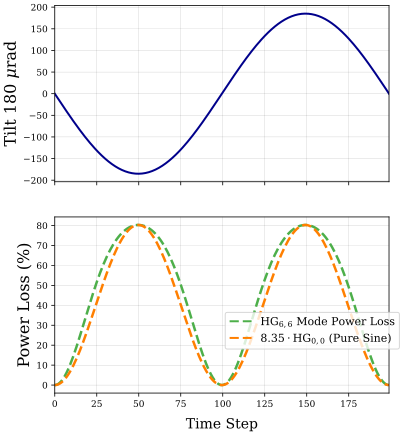

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

ax1.plot(alphas2*1e6, color="darkblue", label="Tilt Angle", alpha=1, lw=2)

ax1.set_ylabel(r"Tilt 180 $\mu$rad", fontsize=16)

# ax2.plot(powerMisalignment_0*100, color=CB_color_cycle[4], ls="-", lw=2, label="$\mathrm{HG}_{0,0}$ Numerical")
ax2.plot(powerMisalignment2*100, color=CB_color_cycle[2], ls="--", lw=2.5, label="$\mathrm{HG}_{6,6}$ Mode Power Loss")

Loss33 = powerMisalignment2.max()/powerMisalignment_0.max()
print(Loss33)
# Loss33 = 3.5
ax2.plot(Loss33*powerMisalignment_0*100, color=CB_color_cycle[1], ls="--", lw=2.5, label="$8.35\cdot \mathrm{HG}_{0,0}$ (Pure Sine)");

length = pd2_33.shape[0]
start = 0.14
end = 0.5
pd2_33_plot = pd2_33[int(length*start):int(length*end)]
# ax2.plot(np.linspace(0, 200, pd2_33_plot.shape[0]), pd2_33_plot*100, color="#43A6C6", ls="-.", lw=0.8,
         # label="$\mathrm{HG}_{3,3}$ Measurement", alpha=0.7)

ax2.set_ylabel("Power Loss (%)", fontsize=16)
ax2.set_xlabel("Time Step", fontsize=14, labelpad=9);

handles1, labels1 = ax2.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# handles1.extend(handles2)
# labels1.extend(labels2)
legend = plt.legend(handles1, labels1, fontsize=11, ncols=1, loc=(0.51, 0.25));

legend_lines = legend.get_lines()
for idx, line in enumerate(legend_lines):
    line.set_linewidth(2)
    
legend_lines[0].set_linestyle((0, (4.6, 2)))
legend_lines[1].set_linestyle((0, (4.6, 2)))
# legend_lines[4].set_linestyle("-")

# fig.savefig('./Experiment Paper/LargeMisalignmentLoss.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [47]:
# handles1[0].set_linewidth = 2